In [1]:
from CNTools.datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import MultiPoint, Point, Polygon
from scipy.spatial import Voronoi
import matplotlib.patches as mpatches
import pickle
import sys
sys.path.insert(0, '..')

In [2]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    adapted from https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647 3.18.2019
    
    
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [3]:
def plot_voronoi(points,colors,invert_y = True,edge_color = 'facecolor',line_width = .1,alpha = 0.1,size_max=np.inf):
    if invert_y:
        points[:,1] = max(points[:,1])-points[:,1]
    vor = Voronoi(points)

    regions, vertices = voronoi_finite_polygons_2d(vor)

    pts = MultiPoint([Point(i) for i in points])
    mask = pts.convex_hull
    new_vertices = []
    if type(alpha)!=list:
        alpha = [alpha]*len(points)
    areas = []
    for i,(region,alph) in enumerate(zip(regions,alpha)):
        polygon = vertices[region]
        shape = list(polygon.shape)
        shape[0] += 1
        p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
        areas+=[p.area]
        if p.area <size_max:
            poly = np.array(list(zip(p.boundary.coords.xy[0][:-1], p.boundary.coords.xy[1][:-1])))
            new_vertices.append(poly)
            if edge_color == 'facecolor':
                plt.fill(*zip(*poly), alpha=alph,edgecolor=  colors[i],linewidth = line_width , facecolor = colors[i])
            else:
                plt.fill(*zip(*poly), alpha=alph,edgecolor=  edge_color,linewidth = line_width, facecolor = colors[i])
        # else:

        #     plt.scatter(np.mean(p.boundary.xy[0]),np.mean(p.boundary.xy[1]),c = colors[i])
    return areas

In [4]:
def draw_voronoi_scatter(spot, cell_order, ind, X='X', Y='Y', voronoi_hue='CN', scatter_hue='CT', figsize=(30, 10),
                         voronoi_palette=sns.color_palette('bright'), scatter_palette=sns.color_palette('bright')+[(0.0, 0.0, 0.0)],
                         voronoi_kwargs={}, scatter_kwargs={}, fname=None):
    '''
    plot voronoi of a region and overlay the location of specific cell types onto this
    
    spot:  cells that are used for voronoi diagram
    c:  cells that are plotted over voronoi
    palette:  color palette used for coloring neighborhoods
    X/Y:  column name used for X/Y locations
    hue:  column name used for neighborhood allocation
    figsize:  size of figure
    voronoi_kwargs:  arguments passed to plot_vornoi function
    scatter_kwargs:  arguments passed to plt.scatter()

    returns sizes of each voronoi to make it easier to pick a size_max argument if necessary
    '''
    neigh_alpha = .2
        
    voronoi_kwargs = {**{'alpha':neigh_alpha},**voronoi_kwargs}
    scatter_kwargs = {**{'s':40,'alpha':1,'marker':'.'},**scatter_kwargs}
    
    fig = plt.figure(figsize=figsize)

    ax = fig.gca()
    colors  = [voronoi_palette[i] for i in spot[voronoi_hue]]
    a = plot_voronoi(spot[[X,Y]].values,
                colors,#[{0:'white',1:'red',2:'purple'}[i] for i in spot['color']],
                    edge_color = 'gray', line_width = .1,
                **voronoi_kwargs)
    
    if len(spot)>0:
        if 'c' not in scatter_kwargs:
            colors  = [scatter_palette[i] for i in spot[scatter_hue]]
            scatter_kwargs['c'] = colors
            
        plt.scatter(x = spot[X],y = (max(spot[Y])-spot[Y].values),
                **scatter_kwargs
                )

    plt.xticks([])
    plt.yticks([])
    
    legend1 = plt.legend(handles=[mpatches.Patch(color=scatter_palette[i], alpha=neigh_alpha, label=ind[i]) for i in range(6)],
                         title='CN', bbox_to_anchor=(1.0, 0.5), loc='upper left', frameon=False)
    ax.add_artist(legend1)

    legend2 = plt.legend(handles=[plt.plot([],[], marker='o', ms=6, ls='', color=c, label=l)[0] for c, l in zip(scatter_palette, cell_order)],
                         title='CT', bbox_to_anchor=(1.0, 1), loc='upper left', frameon=False)

    plt.tight_layout()

    if fname:
        plt.savefig(fname + '.pdf', bbox_inches='tight')

    return a

In [5]:
def draw_voronoi_scatter_crc(spot, cell_order, ind, X='X', Y='Y', voronoi_hue='CN', scatter_hue='CT', figsize=(30, 10),
                             voronoi_palette=sns.color_palette('bright'), scatter_palette=sns.color_palette('bright')+[(0.0, 0.0, 0.0)],
                             voronoi_kwargs={}, scatter_kwargs={}, fname=None):
    '''
    plot voronoi of a region and overlay the location of specific cell types onto this
    
    spot:  cells that are used for voronoi diagram
    c:  cells that are plotted over voronoi
    palette:  color palette used for coloring neighborhoods
    X/Y:  column name used for X/Y locations
    hue:  column name used for neighborhood allocation
    figsize:  size of figure
    voronoi_kwargs:  arguments passed to plot_vornoi function
    scatter_kwargs:  arguments passed to plt.scatter()

    returns sizes of each voronoi to make it easier to pick a size_max argument if necessary
    '''
    neigh_alpha = .2
        
    voronoi_kwargs = {**{'alpha':neigh_alpha},**voronoi_kwargs}
    scatter_kwargs = {**{'s':15,'alpha':1,'marker':'.'},**scatter_kwargs}
    
    fig = plt.figure(figsize=figsize)

    ax = fig.gca()
    colors  = [voronoi_palette[i] for i in spot[voronoi_hue]]
    a = plot_voronoi(spot[[X,Y]].values,
                colors,#[{0:'white',1:'red',2:'purple'}[i] for i in spot['color']],
                    edge_color = 'gray', line_width = .1,
                **voronoi_kwargs)

    pair = {'Granulocytes': 'Granulocytes', 'Vasculature': 'Vasculature', 'CD4+ T cells CD45RO+': 'T cells', 'Tumor cells': 'Tumor cells', 'Stroma': 'Stroma',
            'CD68+CD163+ macrophages': 'Macrophages', 'Adipocytes': 'Others', 'Plasma cells': 'Plasma cells', 'CD8+ T cells': 'T cells', 'Tregs': 'T cells',
            'CD4+ T cells': 'T cells', 'CD11c+ DCs': 'Others', 'B cells': 'B cells', 'CD11b+CD68+ macrophages': 'Macrophages', 'Smooth muscle': 'Smooth muscle',
            'Undefined': 'Others', 'Tumor cells / immune cells': 'Tumor cells / immune cells', 'Immune cells / vasculature': 'Others', 'Immune cells': 'Others',
            'NK cells': 'Others', 'Nerves': 'Others', 'CD68+ macrophages GzmB+': 'Macrophages', 'CD68+ macrophages': 'Macrophages', 'Lymphatics': 'Others',
            'CD11b+ monocytes': 'Others', 'CD4+ T cells GATA3+': 'T cells', 'CD163+ macrophages': 'Macrophages', 'CD3+ T cells': 'T cells'}
    order = ['Tumor cells', 'Macrophages', 'Smooth muscle', 'Granulocytes', 'Stroma', 'T cells', 'B cells', 'Vasculature', 'Plasma cells', 'Tumor cells / immune cells', 'Others']

    if len(spot)>0:
        if 'c' not in scatter_kwargs:
            colors = [scatter_palette[order.index(pair[cell_order[i]])] for i in spot[scatter_hue]]
            scatter_kwargs['c'] = colors
            
        plt.scatter(x = spot[X],y = (max(spot[Y])-spot[Y].values),
                **scatter_kwargs
                )

    plt.xticks([])
    plt.yticks([])
    
    legend1 = plt.legend(handles=[mpatches.Patch(color=scatter_palette[i], alpha=neigh_alpha, label=ind[i]) for i in range(9)],
                         title='CN', bbox_to_anchor=(1.0, 0.5), loc='upper left', frameon=False, fontsize=18, title_fontsize=18)
    ax.add_artist(legend1)

    legend2 = plt.legend(handles=[plt.plot([],[], marker='o', ms=6, ls='', color=c, label=l)[0] for c, l in zip(scatter_palette, cell_order)],
                         title='CT', bbox_to_anchor=(1.0, 1.05), loc='upper left', frameon=False, fontsize=18, title_fontsize=18)

    plt.tight_layout()

    if fname:
        plt.savefig(fname + '.pdf', bbox_inches='tight')

    return a

In [6]:
def plot_voronoi_graph(sample, image, ds, ind, cns, figsize=(30, 10), fname=None, is_crc=False):
    spot = pd.DataFrame({'X': ds.data[sample][image].locs[:, 0], 'Y': ds.data[sample][image].locs[:, 1], 'CN': cns[sample][image], 'CT': ds.data[sample][image].cts_oh.nonzero()[1]})
    if is_crc:
        draw_voronoi_scatter_crc(spot, ds.ct_order, ind, figsize=figsize, fname=fname)
    else:
        draw_voronoi_scatter(spot, ds.ct_order, ind, figsize=figsize, fname=fname)

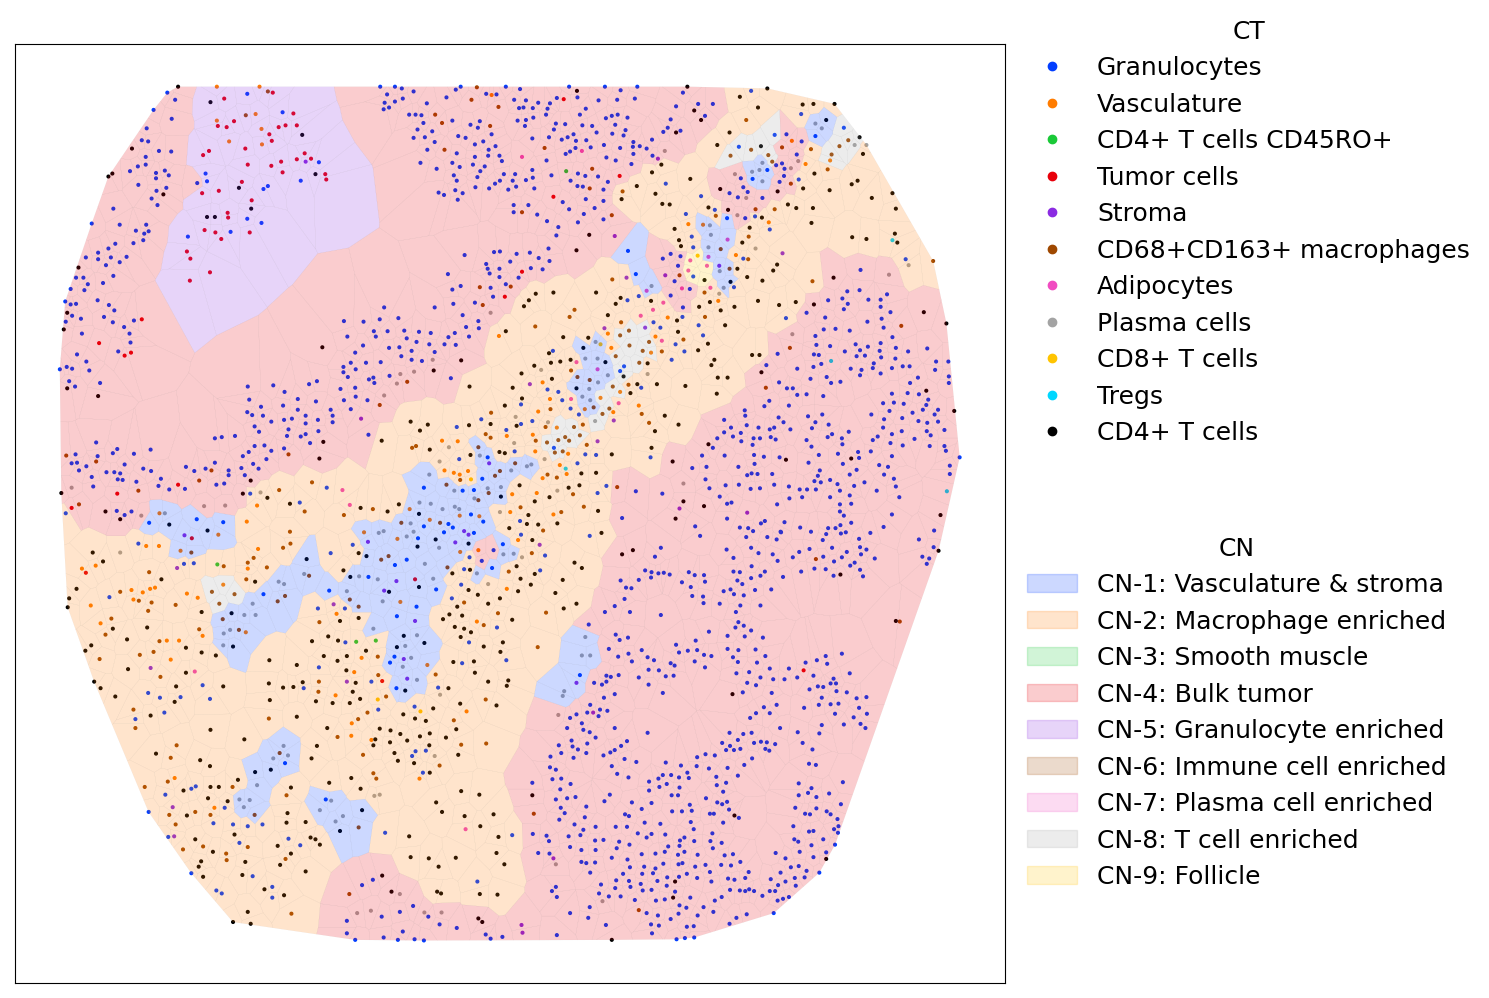

In [15]:
ds = pickle.load(open('../data/CRC/CRC_ds.pkl', 'rb'))
cns = pickle.load(open('../cn/CRC/CNE/cns_n_cns=9_perp=15_lam=0.25_naive.pkl', 'rb'))
ind = ['CN-1: Vasculature & stroma', 'CN-2: Macrophage enriched', 'CN-3: Smooth muscle', 'CN-4: Bulk tumor', 'CN-5: Granulocyte enriched', 'CN-6: Immune cell enriched', 'CN-7: Plasma cell enriched', 'CN-8: T cell enriched', 'CN-9: Follicle']

plot_voronoi_graph(33, 'reg065_A', ds, ind, cns, figsize=(15, 10), fname='../analysis_res/CRC/CNE/vis1', is_crc=True)

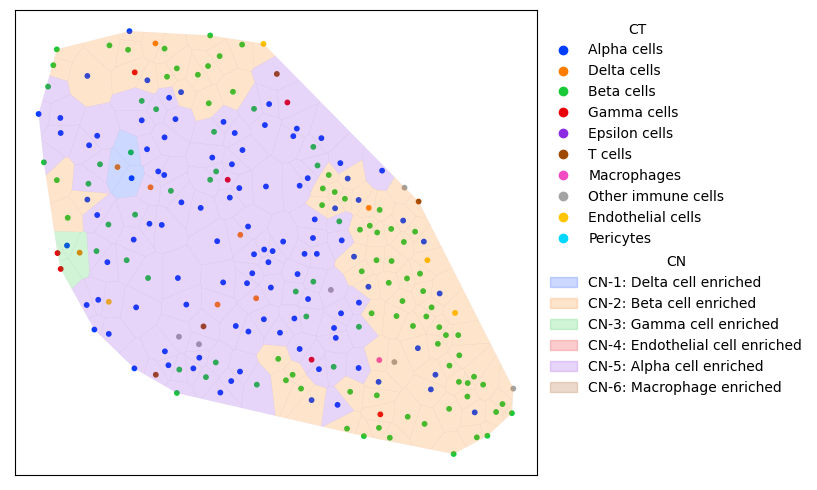

In [16]:
ds = pickle.load(open('../data/T2D/T2D_ds.pkl', 'rb'))
cns = pickle.load(open('../cn/T2D/CNE/cns_n_cns=6_perp=15_lam=0.25_naive.pkl', 'rb'))
ind = ['CN-1: Delta cell enriched', 'CN-2: Beta cell enriched', 'CN-3: Gamma cell enriched', 'CN-4: Endothelial cell enriched', 'CN-5: Alpha cell enriched', 'CN-6: Macrophage enriched']

plot_voronoi_graph('ABHQ115', 2, ds, ind, cns, figsize=(7.5, 5), fname='../analysis_res/T2D/CNE/vis1')